In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sshikamaru_glaucoma_detection_path = kagglehub.dataset_download('sshikamaru/glaucoma-detection')

print('Data source import complete.')


Using Colab cache for faster access to the 'glaucoma-detection' dataset.
Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

from skimage import exposure, util
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing, square
import scipy.io as sio

In [18]:
meta = pd.read_csv("/kaggle/input/glaucoma-detection/glaucoma.csv")
meta

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
...,...,...,...,...,...
645,646.jpg,0.6560,OD,A,1
646,647.jpg,0.7365,OD,A,1
647,648.jpg,0.5101,OS,A,1
648,649.jpg,0.5227,OD,B,0


In [7]:
meta["Glaucoma"].value_counts()

,count
Glaucoma,
0,482
1,168


In [20]:
all_images = glob("/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/*.jpg")
root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
meta["Path"] = meta["Filename"].apply(lambda fn: os.path.join(root, fn))
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma,Path
0,001.jpg,0.7097,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
1,002.jpg,0.6953,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
2,003.jpg,0.9629,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
3,004.jpg,0.7246,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
4,005.jpg,0.6138,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...


In [ ]:
meta.groupby("Glaucoma")["ExpCDR"].mean()

Glaucoma
0    0.542243
1    0.674040
Name: ExpCDR, dtype: float64

### Use Unet model to crop

In [6]:
# --- 1. UNet 类定义 ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = self._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = self._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = self._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = self._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = self._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        self.sigmoid = nn.Sigmoid()

    def _block(self, in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        logits = self.conv(dec1)
        return self.sigmoid(logits)

In [7]:
# --- 2. 图像预处理函数 ---
def get_bounding_box(binary_mask):
    """
    获取二值掩码中最大连通区域的边界框。
    """
    binary = binary_mask > 0
    if not np.any(binary):
        height, width = binary_mask.shape
        return 0, 0, width, height

    labeled_image = label(binary)
    regions = regionprops(labeled_image)
    largest_region = max(regions, key=lambda r: r.area)
    min_row, min_col, max_row, max_col = largest_region.bbox
    return min_col, min_row, max_col - min_col, max_row - min_row


def gamma_correct(img, gamma=0.4):
    """Gamma 校正：提亮暗区细节"""
    img_float = util.img_as_float(img)
    corrected = exposure.adjust_gamma(img_float, gamma=gamma)
    return util.img_as_ubyte(corrected)


def enhance_contrast_clahe(image, clip_limit=0.02, kernel_size=8):
    """CLAHE 局部对比度增强"""
    img_float = util.img_as_float(image)
    enhanced = exposure.equalize_adapthist(
        img_float,
        kernel_size=kernel_size,
        clip_limit=clip_limit
    )
    return util.img_as_ubyte(enhanced)


def segment_optic_disc_from_mat(image_path, mat_dir):
    """
    直接从与图像同名的 .mat 文件中读取视盘标注。
    """
    image_stem = Path(image_path).stem
    mat_path = os.path.join(mat_dir, f"{image_stem}.mat")
    mat_data = sio.loadmat(mat_path)
    mask = mat_data['mask']
    optic_disc_mask = (mask > 0).astype(np.uint8) * 255
    return optic_disc_mask


def segment_optic_disc_by_clustering(gray_image):
    """
    使用 KMeans 分割视盘区域。
    """
    pixel_values = gray_image.reshape(-1, 1).astype(np.float32)
    kmeans = KMeans(n_clusters=6, n_init=3, random_state=0).fit(pixel_values)
    cluster_labels = kmeans.labels_.reshape(gray_image.shape)
    cluster_brightness_means = []
    for cluster_id in range(6):
        pixels_in_cluster = pixel_values[cluster_labels.ravel() == cluster_id]
        mean_brightness = pixels_in_cluster.mean() if len(pixels_in_cluster) > 0 else -np.inf
        cluster_brightness_means.append(mean_brightness)
    brightest_cluster_ids = np.argsort(cluster_brightness_means)[-2:]
    optic_disc_mask = np.isin(cluster_labels, brightest_cluster_ids)
    return (optic_disc_mask * 255).astype(np.uint8)


def segment_optic_disc_with_unet(image_path, unet_model):
    """
    使用 UNet 模型分割视盘区域。
    """
    pil_image = Image.open(image_path).convert('RGB')
    original_img = np.array(pil_image)

    img_tensor = util.img_as_float(original_img)
    img_tensor = resize(img_tensor, (384, 384), anti_aliasing=True)
    img_tensor = torch.FloatTensor(img_tensor).permute(2, 0, 1).unsqueeze(0)
    # 从模型对象获取其所在的设备
    model_device = next(unet_model.parameters()).device
    img_tensor = img_tensor.to(model_device)

    with torch.no_grad():
        output = unet_model(img_tensor)
        mask_pred = output.squeeze().cpu().numpy()
        mask_pred = (mask_pred > 0.5).astype(np.uint8)

    mask_pred = resize(mask_pred, original_img.shape[:2], anti_aliasing=False, order=0)
    mask_pred = (mask_pred > 0.5).astype(np.uint8) * 255

    return mask_pred


def crop_fundus_region(original_image, threshold=10):
    """
    裁剪眼底有效区域（去除黑边/无效区域）。
    """
    if original_image.ndim == 2:
        original_image = np.stack([original_image] * 3, axis=-1)

    gray_image = util.img_as_ubyte(rgb2gray(original_image))

    if np.max(gray_image) <= threshold:
        foreground_mask = np.ones_like(gray_image, dtype=np.uint8) * 255
    else:
        foreground_mask = (gray_image > threshold).astype(np.uint8) * 255

    min_col, min_row, width, height = get_bounding_box(foreground_mask)

    margin = min(100, width // 4, height // 4)
    col_start = max(0, min_col + margin)
    row_start = max(0, min_row + margin)
    col_end = min(original_image.shape[1], min_col + width - margin)
    row_end = min(original_image.shape[0], min_row + height - margin)

    if col_end <= col_start or row_end <= row_start:
        col_start, row_start, col_end, row_end = 0, 0, original_image.shape[1], original_image.shape[0]

    cropped_rgb = original_image[row_start:row_end, col_start:col_end]
    cropped_gray = gray_image[row_start:row_end, col_start:col_end]
    return cropped_rgb, cropped_gray


def refine_mask_with_morphology(binary_mask):
    """通过形态学操作（开+闭）精修二值掩码"""
    binary = binary_mask > 0
    opened = binary_opening(binary, footprint=square(5))
    closed = binary_closing(opened, footprint=square(5))
    return (closed * 255).astype(np.uint8)


def crop_optic_disc_region(rgb_image, optic_disc_mask):
    """
    基于视盘掩码裁剪出包含视盘的局部区域，并缩放到 384x384。
    """
    min_col, min_row, width, height = get_bounding_box(optic_disc_mask)

    scale_x = rgb_image.shape[1] / optic_disc_mask.shape[1]
    scale_y = rgb_image.shape[0] / optic_disc_mask.shape[0]
    min_col = int(min_col * scale_x)
    width = int(width * scale_x)
    min_row = int(min_row * scale_y)
    height = int(height * scale_y)

    center_x = min_col + width // 2
    center_y = min_row + height // 2

    half_crop_size = 250  # 裁剪 500x500 区域
    col_start = max(0, center_x - half_crop_size)
    row_start = max(0, center_y - half_crop_size)
    col_end = min(rgb_image.shape[1], center_x + half_crop_size)
    row_end = min(rgb_image.shape[0], center_y + half_crop_size)

    if col_end <= col_start or row_end <= row_start:
        col_start, row_start = 0, 0
        col_end = min(rgb_image.shape[1], 500)
        row_end = min(rgb_image.shape[0], 500)

    optic_disc_crop = rgb_image[row_start:row_end, col_start:col_end]
    final_optic_disc_crop = util.img_as_ubyte(
        resize(optic_disc_crop, (384, 384), anti_aliasing=True)
    )
    return final_optic_disc_crop



def preprocess_fundus_image(image_path, mat_dir=None, method='unet', unet_model=None, debug=False):
    """
    端到端预处理：输入原始眼底图，输出视盘裁剪图。
    """
    pil_image = Image.open(image_path).convert("RGB")
    original_image = np.array(pil_image)

    cropped_rgb, cropped_gray = crop_fundus_region(original_image, threshold=10)

    enhanced_gray = gamma_correct(cropped_gray, gamma=0.4)
    enhanced_gray = enhance_contrast_clahe(enhanced_gray)

    if method == 'clustering':
        optic_disc_mask = segment_optic_disc_by_clustering(enhanced_gray)
    elif method == 'unet':
        if unet_model is None:
            raise ValueError("method='unet', must provide model")
        optic_disc_mask = segment_optic_disc_with_unet(image_path, unet_model)
    elif method == 'mat':
        if mat_dir is None:
            raise ValueError("method='mat', must provide mat file path")
        optic_disc_mask = segment_optic_disc_from_mat(image_path, mat_dir)
    else:
        raise ValueError(f"unknown mehtod: {method}")

    refined_mask = refine_mask_with_morphology(optic_disc_mask)

    enhanced_rgb = enhance_contrast_clahe(cropped_rgb)
    final_crop = crop_optic_disc_region(enhanced_rgb, refined_mask)

    if debug:
        return {
            "original_image": original_image,
            "cropped_fundus": cropped_rgb,
            "optic_disc_mask": refined_mask,
            "final_optic_disc_crop": final_crop
        }
    else:
        return final_crop

In [8]:
# --- 4. 定义加载模型的函数 ---
def load_model(model_class, model_save_path, in_channels=3, out_channels=1, device=None):
    """
    加载训练好的 PyTorch 模型。
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"use devide: {device}")

    model = model_class(in_channels=in_channels, out_channels=out_channels).to(device)
    model.eval()

    try:
        with torch.serialization.safe_globals([np.dtype, np.core.multiarray.scalar]):
            checkpoint = torch.load(model_save_path, map_location=device, weights_only=True)
    except Exception as e:
        print(f"weights_only=True failed: {e}")
        print("try weights_only=False...")
        checkpoint = torch.load(model_save_path, map_location=device, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"model loaded")
    return model

In [9]:
# --- 5. 批量预处理函数 ---
def batch_preprocess_images(
    input_directory,
    output_directory,
    method='unet',
    unet_model=None,
    image_extension="*.jpg",
    save_quality=95
):
    """
    批量预处理眼底图像（支持 UNet、聚类、MAT 等方法）
    """
    os.makedirs(output_directory, exist_ok=True)
    print(f"output directory exists: {output_directory}")

    image_paths = sorted(glob(os.path.join(input_directory, image_extension)))
    if not image_paths:
        print(f"No any {image_extension} file in {input_directory}")
        return


    for idx, image_path in enumerate(image_paths, 1):
        filename = Path(image_path).name
        print(f" ({idx}/{len(image_paths)}) now: {filename}")

        final_crop = preprocess_fundus_image(
            image_path=image_path,
            method=method,
            unet_model=unet_model if method == 'unet' else None)

        output_filename = Path(image_path).parts[-1]
        output_path = os.path.join(output_directory, output_filename)

        img_to_save = Image.fromarray(final_crop)
        img_to_save.save(output_path, format='JPEG', quality=save_quality)

        print(f" saved in : {output_path}")

def preprocess_single_image(
    image_path: str,
    method: str = 'unet',
    unet_model=None,
    output_directory: str = None,
    save_quality: int = 95 # 控制 JPG 质量
) -> np.ndarray:
    """
    对单张眼底图像进行预处理（例如：UNet分割后裁剪）。

    Args:
        image_path (str): 待处理图片的完整路径。
        method (str): 预处理方法 ('unet' 等)。
        unet_model: 已加载的 UNet 模型实例 (如果 method='unet')。
        output_directory (str, optional): 如果提供，处理后的图像将保存到此目录。
        save_quality (int): JPEG 保存质量 (1-95)，仅对 JPG 有效。

    Returns:
        np.ndarray: 经过裁剪和缩放后的局部图像 NumPy 数组 (384x384x3)。
    """

    # 假设 preprocess_fundus_image 已经定义并可用
    final_crop = preprocess_fundus_image(
        image_path=image_path,
        method=method,
        unet_model=unet_model if method == 'unet' else None
    )

    # ----------------------------------------------------
    # 2. 文件保存（可选，并强制使用 JPG 格式）
    # ----------------------------------------------------
    if output_directory:
        # 确保输出目录存在
        os.makedirs(output_directory, exist_ok=True)

        # 构造输出路径：确保文件名后缀为 .jpg
        output_filename = Path(image_path).parts[-1]
        output_path = os.path.join(output_directory, output_filename)

        # 转换为 PIL 图像
        img_to_save = Image.fromarray(final_crop)

        try:
            img_to_save.save(output_path, format='JPEG', quality=save_quality)
            print(f"✅ 处理结果已保存为 JPG 文件 (Quality={save_quality}) 至: {output_path}")
        except Exception as e:
            print(f"❌ 保存 JPG 文件时出错: {e}")

### Save cropped images

In [ ]:
unet_model = load_model(
    model_class=UNet,
    model_save_path="/kaggle/384_unet.pth",
    in_channels=3,
    out_channels=1
)

batch_preprocess_images(
    input_directory="/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/",
    output_directory="/kaggle/working/cropped_images",
    method='unet',
    unet_model=unet_model,
    image_extension="*.jpg",
    save_quality=95
)


In [21]:
save_path = "/kaggle/working/preprocessed_optic_discs_unet"
meta_gl = meta.loc[meta["Glaucoma"] == 0]
meta_nl = meta.loc[meta["Glaucoma"] == 1]
new_meta = pd.concat([meta_gl.iloc[:170], meta_nl]).copy()

In [17]:
print(new_meta['Path'][0])

/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/001.jpg


# Preparing data for model training and testing

In [23]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(new_meta, test_size=0.25, random_state=0)
print(train_df.shape, test_df.shape)

(253, 6) (85, 6)


In [24]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image

class GlaucomaDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.data = self.get_data()

    def get_data(self):
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"]
            exp_cdr = row["ExpCDR"]
            file_stem = Path(row["Path"]).stem
            name = f"{file_stem}_preprocessed.jpg"
            path = os.path.join(save_path, name)
            data.append(((path, exp_cdr), label))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (img_path, exp_cdr), label = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return (image, torch.FloatTensor([exp_cdr])), label

from torchvision import transforms

train_transforms = transforms.Compose([
    #transforms.Resize((224, 224), antialias=True),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.2),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the transformations for the test dataset
test_transforms = transforms.Compose([
    #transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [25]:
train_data = GlaucomaDataset(train_df, train_transforms)
test_data = GlaucomaDataset(test_df, test_transforms)
b_size = 16
train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=b_size, shuffle=False)

# Model

In [26]:
#试试别的预训练模型
import torch
from torch import nn
from torchvision import models
import torchvision.models as models
import timm

class CombinedModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 使用 EfficientNet-b0
        self.cnn_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        # num_classes=0 会移除最后的分类层，直接输出特征

        num_features = self.cnn_model.num_features

        # 将高维的 EfficientNet 特征降维到 30，以匹配您之前的架构设计。
        # 加入了 ReLU 和 Dropout 以增加非线性和防止过拟合。
        self.cnn_projection = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)
        )

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(30, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x1 = self.cnn_projection(x1)
        x = self.final_layers(x1)
        return x

In [28]:
model = CombinedModel()
model = model.to("cuda:0")

In [29]:
#这个版本不需要手动冻结参数
from fastai.vision.all import *
# 确保引入 LabelSmoothingCrossEntropy，这在医学图像中通常比普通交叉熵更好
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import accuracy, Recall, Precision, F1Score, RocAucBinary

# 重新定义 Learner
# 建议使用 LabelSmoothingCrossEntropy 提高泛化能力
learner = Learner(DataLoaders(train_loader, test_loader), model,
                  metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
                  loss_func=LabelSmoothingCrossEntropy())

# 定义回调函数 (保持不变)
save_best = SaveModelCallback(
    monitor='f1_score',
    fname='best_efficientnet_glaucoma' # 更改保存的文件名以示区别
)

# 早停耐心值可以稍微增加一点，因为微调需要一些时间来适应
early_stop = EarlyStoppingCallback(
    monitor='f1_score',
    min_delta=0.005,
    patience=15
)

print("开始微调训练...")
# --- 使用 fine_tune 进行两阶段训练 ---
# 阶段 1: 冻结 EfficientNet 主干，只训练自定义的头部 (cnn_projection, ff_model, final_layers) 运行 3 个 epoch。
# 阶段 2: 解冻所有层，使用较低的学习率训练 50 个 epoch (受早停控制)。
# base_lr: 这是第二阶段的最大学习率。第一阶段的学习率默认是它的 1/10。
learner.fine_tune(
    epochs=50,          # 解冻后训练的最大轮数
    base_lr=1e-3,       # 基础学习率
    freeze_epochs=3,    # 冻结训练的轮数
    cbs=[early_stop, save_best]
)

开始微调训练...


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time


KeyboardInterrupt: 

In [28]:
#绘图函数
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(learner,fold,title="Training History"):
    """
    从 FastAI Learner 中提取数据并绘制专业的 Loss 和 Metrics 曲线
    """
    # 1. 提取数据
    # recorder.values 是一个列表，每一行对应一个 epoch
    # 每一行的列顺序对应 learner.recorder.metric_names
    values = np.array(learner.recorder.values)
    metric_names = learner.recorder.metric_names

    # FastAI 的 metric_names 通常是 ['epoch', 'train_loss', 'valid_loss', 'accuracy', 'f1_score', 'roc_auc_binary', ...]
    # 注意：values 里不包含 'epoch' 列，所以索引要偏移

    # 找到对应的索引 (自动查找，防止顺序变动)
    try:
        idx_train_loss = metric_names.index('train_loss') - 1
        idx_valid_loss = metric_names.index('valid_loss') - 1
        idx_f1 = metric_names.index('f1_score') - 1
        idx_auc = metric_names.index('roc_auc_score') - 1
    except ValueError:
        print("错误: 找不到指定的指标名称，请检查 learner.recorder.metric_names")
        print("当前可用指标:", metric_names)
        return

    # 提取列数据
    train_losses = values[:, idx_train_loss]
    valid_losses = values[:, idx_valid_loss]
    f1_scores = values[:, idx_f1]
    auc_scores = values[:, idx_auc]
    epochs = range(1, len(train_losses) + 1)

    # 2. 设置绘图风格
    plt.style.use('seaborn-v0_8-whitegrid') # 使用整洁的网格风格
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- 图 1: Loss 曲线 ---
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, valid_losses, 'r--', label='Valid Loss', linewidth=2)
    ax1.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # 标记最佳验证 Loss 点
    min_loss_idx = np.argmin(valid_losses)
    ax1.scatter(epochs[min_loss_idx], valid_losses[min_loss_idx], s=100, c='red', marker='*')

    # --- 图 2: Metrics 曲线 (F1 & AUC) ---
    ax2.plot(epochs, f1_scores, 'g-', label='F1 Score', linewidth=2, marker='.')
    ax2.plot(epochs, auc_scores, 'purple', label='ROC-AUC', linewidth=2, linestyle='--', marker='.')

    ax2.set_title(f'{title} - Metrics', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('F1_Score', fontsize=12)
    ax2.set_ylim(0, 1.05) # 固定 y 轴范围 0-1
    ax2.legend(fontsize=12, loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # 标记最佳 F1 点
    max_f1_idx = np.argmax(f1_scores)
    ax2.scatter(epochs[max_f1_idx], f1_scores[max_f1_idx], s=100, c='green', marker='*')
    SAVE_FILENAME = f'/kaggle/working/KFold_Training_Curves_{fold+1}.png'
    plt.savefig(SAVE_FILENAME, dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

In [ ]:
# 假设您在之前设置了保存文件名
MODEL_FNAME = 'best_efficientnet_glaucoma'

# 确保 Learner 实例 (learner) 已经定义并可用。
# 如果您在新的环境中运行，需要重新定义模型和 Learner 实例。

# 载入最佳模型权重
# fastai 会在 learner.path/models/ 目录下查找名为 MODEL_FNAME 的文件
learner.load(MODEL_FNAME)

print(f"已成功载入模型权重：{learner.path}/models/{MODEL_FNAME}.pth")

# 使用 learner.validate() 方法进行评估
# 返回值是一个列表，第一个元素是损失值 (valid_loss)，后面是所有在 Learner 中定义的评估指标
results = learner.validate()

# 提取并打印结果
# 结果列表的结构对应于：[valid_loss, accuracy, recall, precision, f1_score, roc_auc_binary]
print("\n--- 验证集（Test Loader）评估结果 ---")
print(f"验证损失 (Valid Loss): {results[0]:.4f}")
print(f"准确率 (Accuracy): {results[1]:.4f}")
print(f"召回率 (Recall): {results[2]:.4f}")
print(f"精确率 (Precision): {results[3]:.4f}")
print(f"F1 分数 (F1 Score): {results[4]:.4f}")
print(f"ROC-AUC: {results[5]:.4f}")

# 注意：results 列表中指标的顺序取决于您定义 Learner 时 metrics=[...] 的顺序。
# 如果您使用了完整的 fastai 导入，上面的索引顺序应该是正确的。

已成功载入模型权重：./models/best_efficientnet_glaucoma.pth


# K-fold


--- 🚀 Starting Fold 1/5 ---
Fold 1: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.683338,0.671957,0.617647,0.235294,1.000000,0.380952,0.724048,00:09
1,0.595921,1.000737,0.691176,0.500000,0.809524,0.618182,0.700692,00:09
2,0.544510,1.963532,0.588235,0.852941,0.557692,0.674419,0.754325,00:09


Better model found at epoch 0 with f1_score value: 0.38095238095238093.
Better model found at epoch 1 with f1_score value: 0.6181818181818182.
Better model found at epoch 2 with f1_score value: 0.6744186046511628.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.395002,0.795310,0.750000,0.617647,0.840000,0.711864,0.787197,00:09
1,0.330476,0.667350,0.764706,0.676471,0.821429,0.741935,0.814879,00:09
2,0.308149,0.643355,0.735294,0.705882,0.750000,0.727273,0.791522,00:09
3,0.288501,0.730066,0.661765,0.617647,0.677419,0.646154,0.769031,00:09
4,0.269268,0.748431,0.691176,0.676471,0.696970,0.686567,0.759516,00:09
5,0.265289,0.771631,0.705882,0.735294,0.694444,0.714286,0.769031,00:09
6,0.268762,0.771228,0.705882,0.676471,0.718750,0.696970,0.762111,00:09
7,0.265912,0.881951,0.632353,0.764706,0.604651,0.675325,0.726644,00:09
8,0.263296,0.854945,0.735294,0.558824,0.863636,0.678571,0.786332,00:09
9,0.264055,0.770839,0.720588,0.676471,0.741935,0.707692,0.786332,00:09


Better model found at epoch 0 with f1_score value: 0.711864406779661.
Better model found at epoch 1 with f1_score value: 0.7419354838709677.
Better model found at epoch 13 with f1_score value: 0.7741935483870968.
No improvement since epoch 13: early stopping


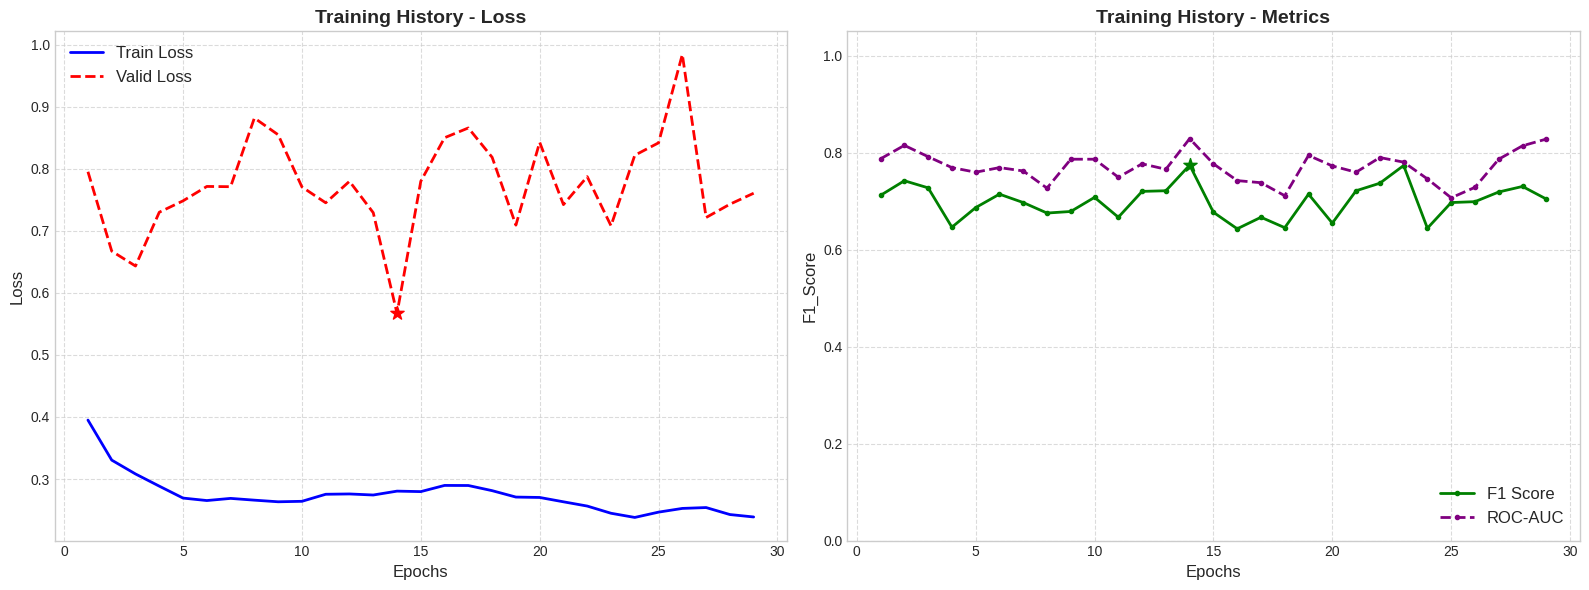

✅ Fold 1 Completed. F1 Score: 0.7742, AUC: 0.8287

--- 🚀 Starting Fold 2/5 ---
Fold 2: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.693317,0.677789,0.573529,0.176471,0.857143,0.292683,0.744810,00:09
1,0.633123,1.049760,0.632353,0.970588,0.578947,0.725275,0.598616,00:09
2,0.585539,0.657612,0.794118,0.764706,0.812500,0.787879,0.837370,00:09


Better model found at epoch 0 with f1_score value: 0.2926829268292683.
Better model found at epoch 1 with f1_score value: 0.7252747252747253.
Better model found at epoch 2 with f1_score value: 0.7878787878787878.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.418413,0.558083,0.779412,0.764706,0.787879,0.776119,0.852941,00:09
1,0.362524,0.604038,0.705882,0.588235,0.769231,0.666667,0.843426,00:09
2,0.326491,0.556576,0.808824,0.764706,0.838710,0.800000,0.856401,00:09
3,0.298221,0.646194,0.764706,0.588235,0.909091,0.714286,0.859862,00:09
4,0.280852,0.579962,0.735294,0.647059,0.785714,0.709677,0.854671,00:09
5,0.265990,0.622690,0.750000,0.735294,0.757576,0.746269,0.839965,00:09
6,0.261845,0.594865,0.779412,0.647059,0.880000,0.745763,0.861592,00:09
7,0.253740,0.788568,0.705882,0.558824,0.791667,0.655172,0.812284,00:09
8,0.256194,0.626266,0.764706,0.735294,0.781250,0.757576,0.851211,00:09
9,0.262862,0.652716,0.750000,0.705882,0.774194,0.738462,0.806228,00:09


Better model found at epoch 0 with f1_score value: 0.7761194029850746.
Better model found at epoch 2 with f1_score value: 0.8.
No improvement since epoch 2: early stopping


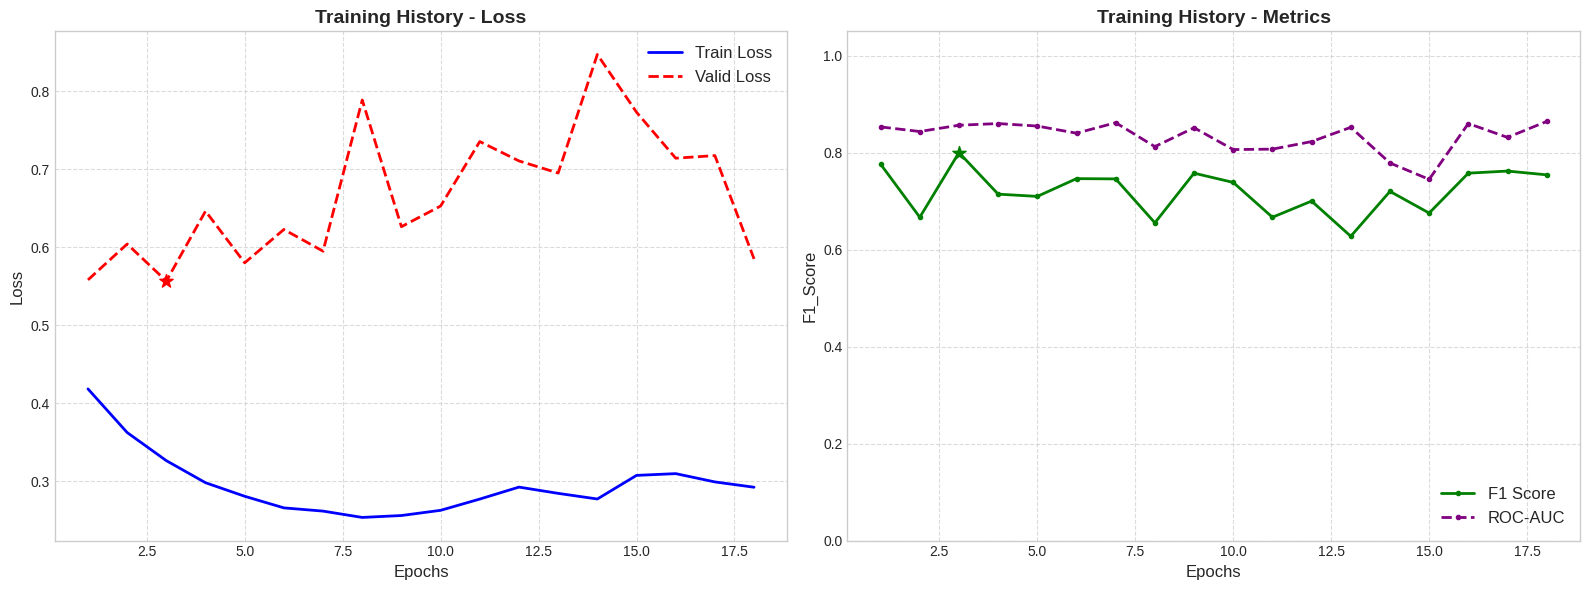

✅ Fold 2 Completed. F1 Score: 0.8000, AUC: 0.8564

--- 🚀 Starting Fold 3/5 ---
Fold 3: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.704699,0.668905,0.500000,1.000000,0.500000,0.666667,0.907439,00:09
1,0.651172,0.716219,0.676471,0.352941,1.000000,0.521739,0.913495,00:09
2,0.636323,0.744746,0.720588,0.676471,0.741935,0.707692,0.818339,00:09


Better model found at epoch 0 with f1_score value: 0.6666666666666666.
Better model found at epoch 2 with f1_score value: 0.7076923076923077.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.511679,0.434220,0.852941,0.911765,0.815789,0.861111,0.942042,00:09
1,0.435486,0.337477,0.926471,0.852941,1.000000,0.920635,0.993080,00:09
2,0.399902,0.398778,0.897059,0.911765,0.885714,0.898551,0.961938,00:09
3,0.362682,0.360719,0.926471,0.911765,0.939394,0.925373,0.974913,00:09
4,0.335404,0.322612,0.911765,0.823529,1.000000,0.903226,0.992215,00:09
5,0.308170,0.259956,0.970588,0.941176,1.000000,0.969697,1.000000,00:09
6,0.287526,0.382577,0.897059,0.941176,0.864865,0.901408,0.972318,00:09
7,0.287742,0.367343,0.882353,0.794118,0.964286,0.870968,0.982699,00:09
8,0.304407,0.546845,0.779412,0.617647,0.913043,0.736842,0.891869,00:09
9,0.315872,0.456679,0.838235,0.823529,0.848485,0.835821,0.916090,00:09


Better model found at epoch 0 with f1_score value: 0.8611111111111112.
Better model found at epoch 1 with f1_score value: 0.9206349206349206.
Better model found at epoch 3 with f1_score value: 0.9253731343283582.
Better model found at epoch 5 with f1_score value: 0.9696969696969697.
No improvement since epoch 5: early stopping


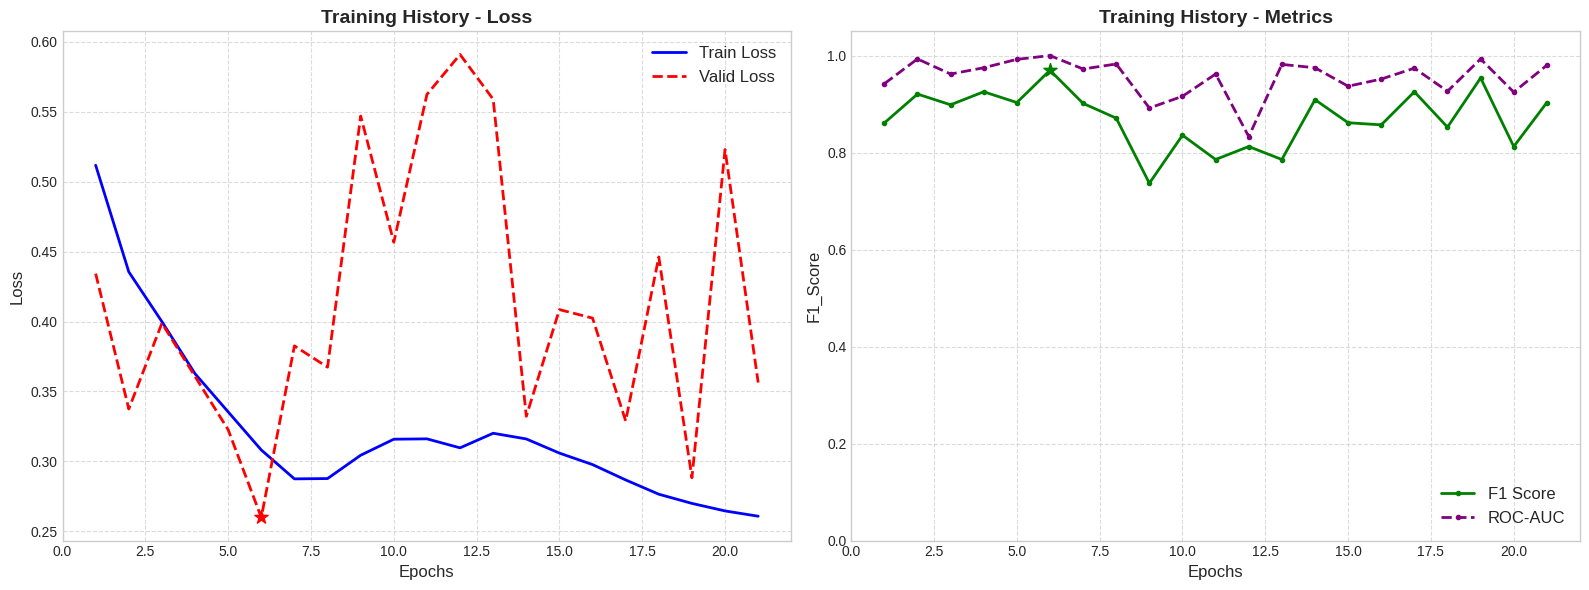

✅ Fold 3 Completed. F1 Score: 0.9697, AUC: 1.0000

--- 🚀 Starting Fold 4/5 ---
Fold 4: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.687358,0.680333,0.626866,0.484848,0.666667,0.561404,0.753119,00:09
1,0.634739,0.634153,0.686567,0.575758,0.730769,0.644068,0.729947,00:09
2,0.596353,0.581534,0.686567,0.575758,0.730769,0.644068,0.825312,00:09


Better model found at epoch 0 with f1_score value: 0.5614035087719298.
Better model found at epoch 1 with f1_score value: 0.6440677966101694.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.463611,0.507583,0.731343,0.757576,0.714286,0.735294,0.872549,00:09
1,0.384746,0.537413,0.731343,0.696970,0.741935,0.718750,0.852050,00:09
2,0.335108,0.526754,0.761194,0.636364,0.840000,0.724138,0.877005,00:09
3,0.316764,0.590394,0.761194,0.606061,0.869565,0.714286,0.846702,00:09
4,0.295443,0.547680,0.805970,0.787879,0.812500,0.800000,0.877005,00:09
5,0.276927,0.571513,0.746269,0.878788,0.690476,0.773333,0.869875,00:09
6,0.270460,0.583507,0.805970,0.878788,0.763158,0.816901,0.864528,00:09
7,0.266271,0.816680,0.686567,0.393939,0.928571,0.553191,0.868093,00:09
8,0.294036,0.601092,0.746269,0.787879,0.722222,0.753623,0.811943,00:09
9,0.287459,0.687045,0.716418,0.696970,0.718750,0.707692,0.814617,00:09


Better model found at epoch 0 with f1_score value: 0.7352941176470589.
Better model found at epoch 4 with f1_score value: 0.8.
Better model found at epoch 6 with f1_score value: 0.8169014084507042.
Better model found at epoch 11 with f1_score value: 0.8235294117647058.
Better model found at epoch 12 with f1_score value: 0.8695652173913043.
No improvement since epoch 12: early stopping


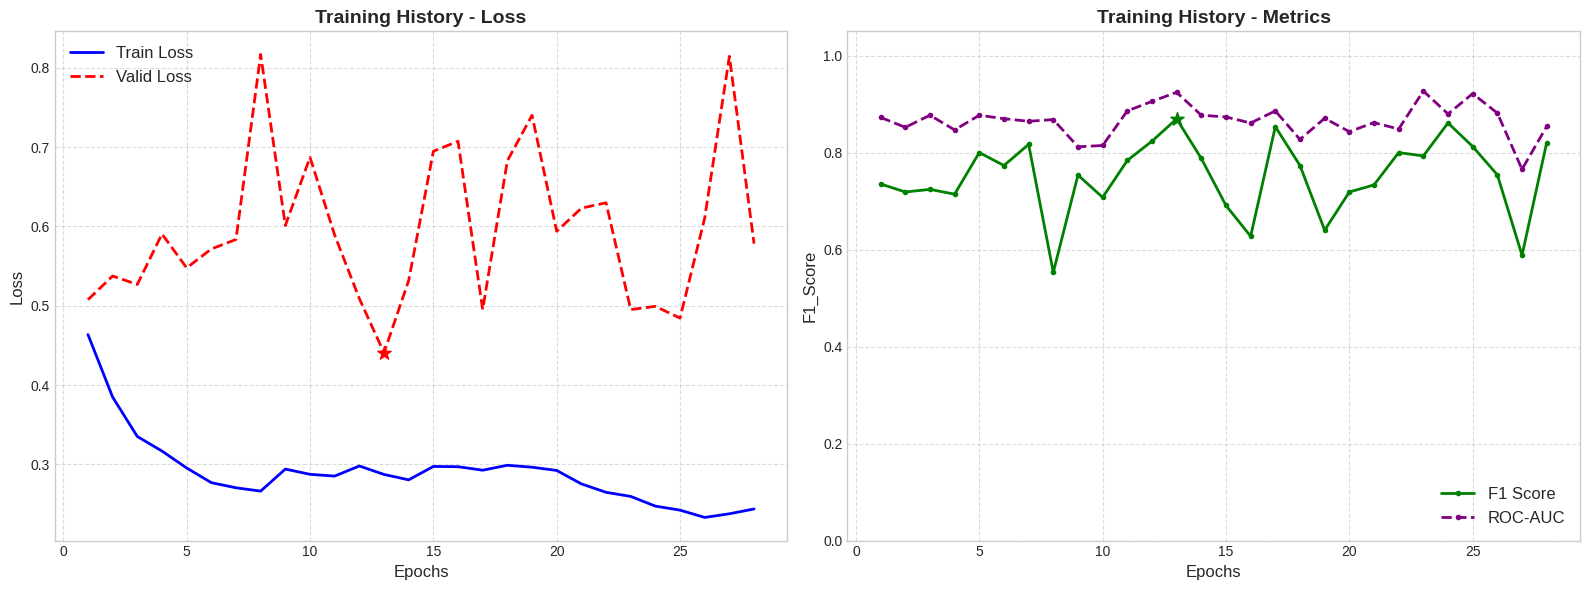

✅ Fold 4 Completed. F1 Score: 0.8696, AUC: 0.9242

--- 🚀 Starting Fold 5/5 ---
Fold 5: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.685800,0.664659,0.716418,0.545455,0.818182,0.654545,0.799465,00:09
1,0.626658,0.610694,0.626866,0.969697,0.571429,0.719101,0.832442,00:09
2,0.577287,0.767247,0.701493,0.666667,0.709677,0.687500,0.835116,00:09


Better model found at epoch 0 with f1_score value: 0.6545454545454545.
Better model found at epoch 1 with f1_score value: 0.7191011235955056.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.373640,0.571190,0.761194,0.787879,0.742857,0.764706,0.868984,00:09
1,0.326919,0.654150,0.716418,0.757576,0.694444,0.724638,0.816399,00:09
2,0.307886,0.561678,0.761194,0.818182,0.729730,0.771429,0.865419,00:09
3,0.277865,0.557228,0.761194,0.818182,0.729730,0.771429,0.869875,00:09
4,0.299778,0.520627,0.850746,0.909091,0.810811,0.857143,0.886809,00:09
5,0.297893,0.455983,0.850746,0.878788,0.828571,0.852941,0.918895,00:09
6,0.291775,0.591590,0.776119,0.909091,0.714286,0.800000,0.864528,00:09
7,0.276623,0.623497,0.761194,0.939394,0.688889,0.794872,0.891266,00:09
8,0.264869,0.625345,0.776119,0.727273,0.800000,0.761905,0.887701,00:09
9,0.273549,0.652039,0.805970,0.939394,0.738095,0.826667,0.868093,00:09


Better model found at epoch 0 with f1_score value: 0.7647058823529411.
Better model found at epoch 2 with f1_score value: 0.7714285714285715.
Better model found at epoch 4 with f1_score value: 0.8571428571428571.
No improvement since epoch 4: early stopping


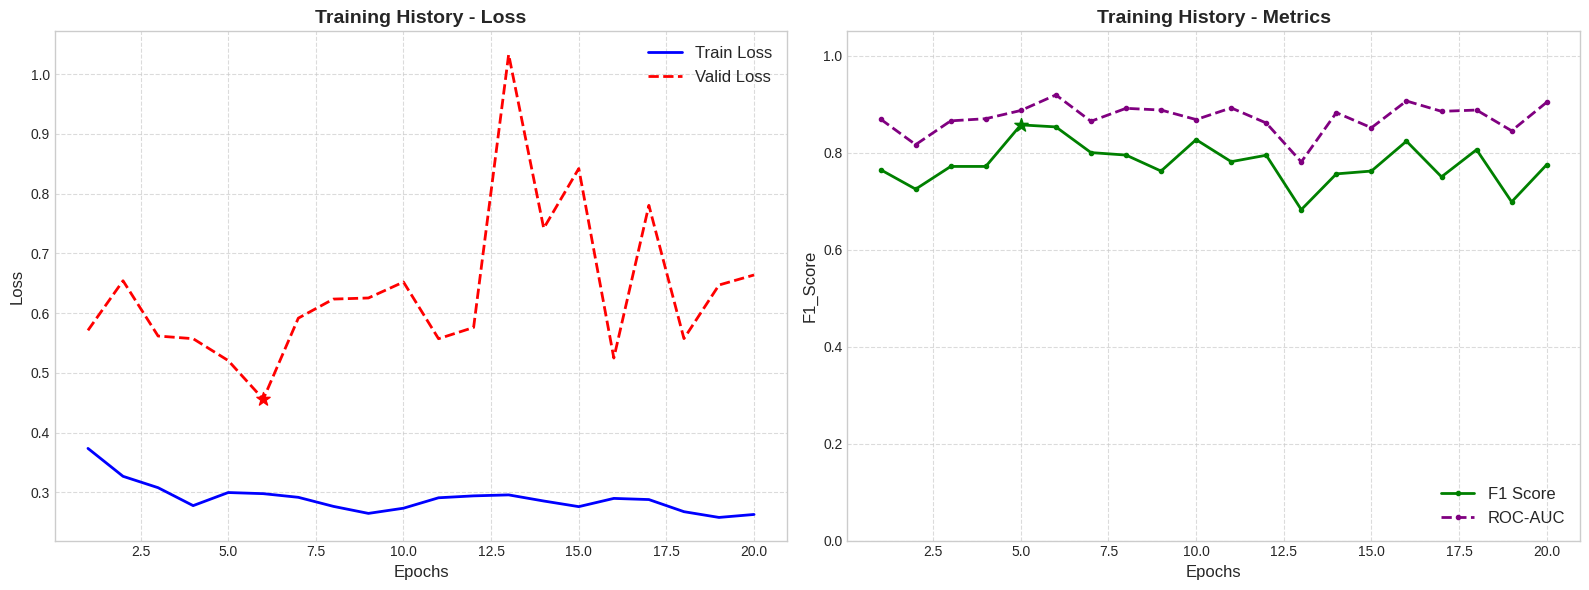

✅ Fold 5 Completed. F1 Score: 0.8571, AUC: 0.8868

--- K-Fold 最终结果 ---
   Fold        F1       AUC
0     1  0.774194  0.828720
1     2  0.800000  0.856401
2     3  0.969697  1.000000
3     4  0.869565  0.924242
4     5  0.857143  0.886809
------------------------
平均 F1 Score: 0.8541 ± 0.0757
平均 AUC Score: 0.8992 ± 0.0666


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from fastai.vision.all import *
from pathlib import Path

# 1. 定义你想要的保存目录
OUTPUT_DIR = Path('/kaggle/working')
OUTPUT_DIR.mkdir(exist_ok=True) # 确保目录存在

# --- 1. 参数与数据准备 ---

# 假设你的所有数据都在这个 DataFrame 中，且包含 'label' 和 'path' 列
df = new_meta# 你的完整数据集 DataFrame

N_SPLITS = 5  # K 值，通常使用 5 或 10
RANDOM_STATE = 42
all_fold_metrics = []

# 初始化 KFold 分割器。
# shuffle=True 非常重要，可以打乱数据后再分割。
# StratifiedKFold (分层K折) 更好，因为它能保证每个折叠的标签比例相似。
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)


# --- 2. K-Fold 训练主循环 ---

# kf.split() 返回的是数据的索引
for fold, (train_index, val_index) in enumerate(kf.split(df, df['Glaucoma'])):

    print(f"\n--- 🚀 Starting Fold {fold+1}/{N_SPLITS} ---")

    # A. 划分训练集和验证集的 DataFrame
    train_df = df.iloc[train_index].reset_index(drop=True)
    val_df = df.iloc[val_index].reset_index(drop=True)

    print(f"Fold {fold+1}: Train size={len(train_df)}, Validation size={len(val_df)}")

    # B. 创建数据集和数据加载器 (DataLoaders)
    # ⚠️ 注意：这里需要使用你的 GlaucomaDataset 类
    train_ds = GlaucomaDataset(train_df, train_transforms)
    val_ds = GlaucomaDataset(val_df, test_transforms)

    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16)
    dls = DataLoaders(train_dl, val_dl)


    # C. 初始化新模型 (⚠️ 关键步骤！)
    # 每一折都必须重新实例化模型和 Learner，以确保权重是独立的。
    # 使用你当前效果最好的模型架构 (ResNet/EfficientNet)
    torch.cuda.empty_cache() # 清理显存，防止内存溢出
    model = CombinedModel() # 重新创建模型实例
    model = model.to("cuda:0")


    # D. 设置 Learner 和回调函数
    # 使用你之前定义的指标、Loss和自定义回调 (如 CombinedMixUp)
    # 将模型文件名改为包含 fold 号，方便保存和加载
    learner = Learner(dls, model, path=OUTPUT_DIR,
              metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
              loss_func=LabelSmoothingCrossEntropyFlat()
                    )

    save_cb = SaveModelCallback(monitor='f1_score', fname=f'best_fold_{fold+1}', comp=np.greater)
    early_cb = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=15)


    # E. 训练和保存最佳模型
    learner.fine_tune(
        epochs=50,
        base_lr=2e-3,
        freeze_epochs=3,
        cbs=[save_cb, early_cb]
    )
    plot_training_history(learner,fold)

    # F. 验证和记录结果
    learner.load(f'best_fold_{fold+1}') # 加载该折的最佳权重
    metrics = learner.validate()

    # 记录该折的 F1Score 和 AUC (假设它们是 metrics 列表中的第三和第四个元素)
    f1_score = metrics[4]
    roc_auc = metrics[5]
    all_fold_metrics.append({'Fold': fold+1, 'F1': f1_score, 'AUC': roc_auc})

    print(f"✅ Fold {fold+1} Completed. F1 Score: {f1_score:.4f}, AUC: {roc_auc:.4f}")


# --- 3. 结果汇总与评估 ---

final_results_df = pd.DataFrame(all_fold_metrics)
print("\n--- K-Fold 最终结果 ---")
print(final_results_df)
print("------------------------")
print(f"平均 F1 Score: {final_results_df['F1'].mean():.4f} ± {final_results_df['F1'].std():.4f}")
print(f"平均 AUC Score: {final_results_df['AUC'].mean():.4f} ± {final_results_df['AUC'].std():.4f}")